In [12]:
# We import all our dependencies.
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer

import sys
sys.path.append('../')

from models.lvae import LadderVAE
from boilerplate import boilerplate
import lib.utils as utils
import training

import os
import glob
import zipfile
import urllib
from tifffile import imread, imsave
from matplotlib import pyplot as plt
from tqdm import tqdm

from pathlib import Path
from pystackreg import StackReg
from skimage.transform import warp,AffineTransform
import cv2

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [14]:
def crop_center(img,crop_size):

    if type(crop_size) == tuple:
        crop_x,crop_y = crop_size
    elif type(crop_size) == int:
        crop_x = crop_size
        crop_y = crop_size
    
    y,x = img.shape[-2::]
    startx = x//2-(crop_x//2)
    starty = y//2-(crop_y//2)        

    return img[...,starty:starty+crop_y,startx:startx+crop_x]

In [15]:
#### ALL PARAMETERS DEFINED HERE ####
initial_crop_size = 1392
crop_size_inference = 400
im_size = initial_crop_size
start = im_size//2-crop_size_inference//2
stop = im_size//2+crop_size_inference//2
# Data paths
data_path = Path(r"E:\dl_monalisa\Data\Actin_fixed_mltplSNR_30nm_2\dump")

# Data parameters
upsamp = 1
DataNoiseLvl = "all"
clip = -3
registration = False
normSignalToObs = True
normGMM = True

# Inference parameters
n_pred = 1 # number of images to predict
num_samples = 100 # number of samples used to compute MMSE estimate
tta = False

# Model loading
modelName = "Actin_live_timelapses_Noiseall_GMMall_Clip-3_5Lat_6Blocks_betaKL0.2_NoAugment_best_vae"
modelPath = Path("./Trained_model/model/") / (modelName + ".net")
# modelPath = Path("C:/Users/guillaume.minet/Documents/GitHub/HDN_tests/Trained_model/model/") / (modelName + ".net")

model = torch.load(modelPath)
model.mode_pred=True
model.eval()


# Saving path and options
save_idx = 1
data_name = str(data_path).split("\\")[3]
save_folder = Path(r"E:\dl_monalisa\Data") / data_name / r"inference\HDN\denoising" / (modelName) #f"_{save_idx}")

overwrite = True
save_samples = True
save_mmse = True
save_std = False
save_var = False

if not os.path.exists(save_folder):
    os.makedirs(save_folder)
else:
    assert overwrite == True, "Saving folder already exists. Set overwrite = True to enable overwriting inference folder"

In [16]:
# Load data

##### Load data ####

signal = []
observation = []
filters = ['tif','tiff']

files = os.listdir(data_path)

for f in files:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} in signals because not in filters")
        files.remove(f)

for f in files:
    if f.split('.')[-1] not in filters:
        print(f"Removing {f} in observations because not in filters")
        files.remove(f)

print(f"\nFound {len(files)} files.\n")

if isinstance(DataNoiseLvl,list) or DataNoiseLvl == "all":
    mltplNoise = True
else:
    mltplNoise = False

for i,f in enumerate(files):

    # avg signal
    im_signal = np.mean(imread(data_path / f)[0:5],axis=0)

    # noise level selection
    if DataNoiseLvl == "all":
        im_obs  = imread(data_path / f)
    elif isinstance(DataNoiseLvl,int) or isinstance(DataNoiseLvl,list):
        im_obs = imread(data_path / f)[DataNoiseLvl]

    if not isinstance(clip,bool):
        im_obs[im_obs<clip] = 0
        im_signal[im_signal<clip] = 0

    if registration:
        if DataNoiseLvl == "all":
            print("Registration not available for all noise level yet")
        else:
            tf = StackReg.TRANSLATION
            sr = StackReg(tf)
            tmat = sr.register(ref=im_signal,mov=im_obs)
            tform = AffineTransform(matrix=tmat)
            im_obs = warp(im_obs, tform,order=0)

    im_obs = crop_center(im_obs,initial_crop_size)
    im_signal = crop_center(im_signal,initial_crop_size)
    
    observation.append(im_obs)
    signal.append(im_signal)

    print(f"File {f}: shape: {im_obs.shape}")

    if i+1 >= n_pred:
        print(f"Stop loading file at file {i} because reached n_pred {n_pred}")
        break

full_signal = []
full_obs = []
if mltplNoise:
    nNoise = []
    for i,obs in enumerate(observation):
        nNoise.append(obs.shape[0])
        sig = signal[i]
        if normSignalToObs:
            sig = (sig - np.mean(sig))/np.std(sig)
        for frame in obs:
            if normSignalToObs:
                norm_sig = sig * np.std(frame) + np.mean(frame)
                full_signal.append(norm_sig)
            else:
                full_signal.append(sig)

            full_obs.append(frame)
    observation = np.stack(full_obs)
    signal = np.stack(full_signal)
else:
    observation = np.stack(observation)
    signal = np.stack(signal)


if normGMM:
    signal = (signal - np.mean(observation)) / np.std(observation)
    observation = (observation - np.mean(observation)) / np.std(observation)


# Cropping
signal = signal[...,start:stop,start:stop]
observation = observation[...,start:stop,start:stop]

#optional downsampling
# if upsamp>1:
#     signal2 = []
#     observation2 = []
#     for im in observation:
#         dwnsamp=im[::upsamp,::upsamp]
#         # interp=cv2.resize(dwnsamp, None, fx=upsamp, fy=upsamp, interpolation= cv2.INTER_CUBIC)
#         observation2.append(dwnsamp)
#     observation = np.stack(observation2)
#     # for im in signal:
#     #     dwnsamp=im[::upsamp,::upsamp]
#     #     interp=cv2.resize(dwnsamp, None, fx=upsamp, fy=upsamp, interpolation= cv2.INTER_NEAREST)
#     #     signal2.append(interp)
#     # signal = np.stack(signal2)

print(f"\n\nConcatenated arrays and cropped:\tSignal: {signal.shape}\tObservation: {observation.shape}")



removing info.txt in signals because not in filters
removing Thumbs.db in signals because not in filters
Removing selected_data in observations because not in filters

Found 39 files.

File 19h11m23s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (10, 1392, 1392)
Stop loading file at file 0 because reached n_pred 1


Concatenated arrays and cropped:	Signal: (10, 400, 400)	Observation: (10, 400, 400)


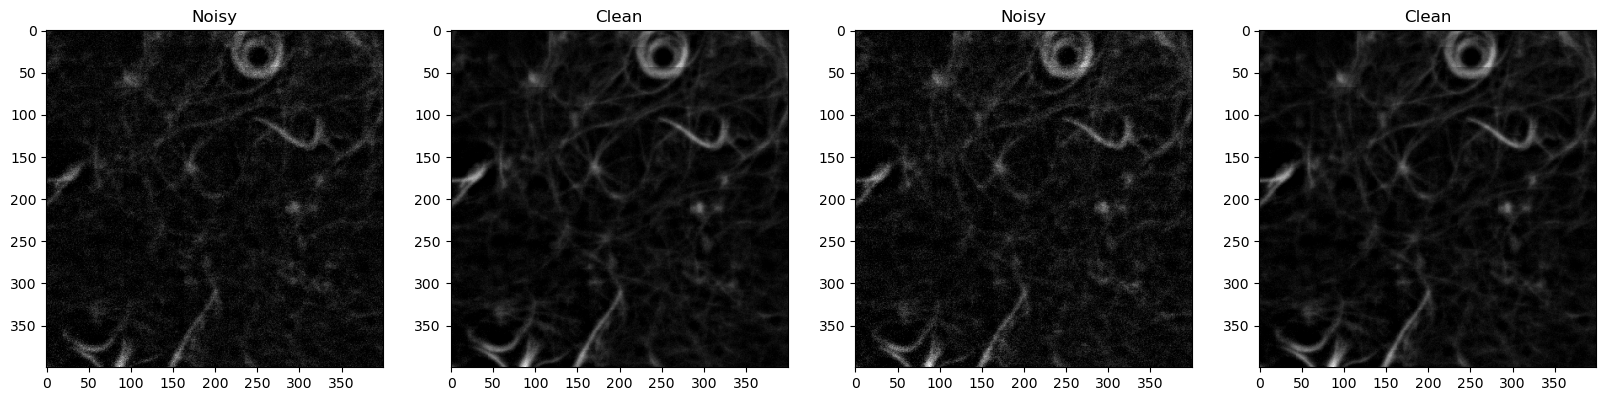

In [17]:
# Display examples

idxs = np.random.randint(0,observation.shape[0],2)

plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.imshow(observation[idxs[0]],cmap="gray")
plt.title("Noisy")

plt.subplot(1,4,2)
plt.imshow(signal[idxs[0]],cmap="gray")
plt.title("Clean")

plt.subplot(1,4,3)
plt.imshow(observation[idxs[1]],cmap="gray")
plt.title("Noisy")

plt.subplot(1,4,4)
plt.imshow(signal[idxs[1]],cmap="gray")
plt.title("Clean")

plt.show()

In [18]:
gaussian_noise_std = None
img_mmse_list = []
samples_list = []
for i in range(observation.shape[0]):
        img_mmse, samples = boilerplate.predict(observation[i],num_samples,model,gaussian_noise_std,device,tta)
        img_mmse_list.append(img_mmse)
        samples_list.append(np.stack(samples))

        

100%|██████████| 100/100 [00:11<00:00,  8.71it/s]


In [19]:
### saving solutions
counter = 0
for i in range(n_pred):    
    if mltplNoise:
        summary = [signal[counter]]
        for noise in range(nNoise[i]):
            # obs = cv2.resize(observation[i*N+noise],None,fx=upsamp, fy=upsamp, interpolation= cv2.INTER_NEAREST)
            summary.append(observation[counter])
            summary.append(img_mmse_list[counter])
            samples = samples_list[counter] 
            std = np.std(samples,axis=0)
            std_norm = std / img_mmse_list[counter]
            var = np.var(samples,axis=0)
            var_norm = var / img_mmse_list[counter]
            if save_samples:
                imsave(save_folder / f"samples_{i:02d}_Noise{noise}_{i:02d}.tif",samples)
            if save_std:
                imsave(save_folder / f"std_{i:02d}_Noise{noise}_{i:02d}.tif",std)
                imsave(save_folder / f"std_norm{i:02d}_Noise{noise}_{i:02d}.tif",std_norm)
            if save_var:
                imsave(save_folder / f"var_{i:02d}_Noise{noise}_{i:02d}.tif",var)
                imsave(save_folder / f"var_norm{i:02d}_Noise{noise}_{i:02d}.tif",var_norm)
            counter+=1
        summary=np.stack(summary,axis=0)

        if save_mmse:
            if isinstance(DataNoiseLvl,list):
                noise_level_str = ''.join(str(DataNoiseLvl).split(', '))[1:-1]
            else:
                noise_level_str = DataNoiseLvl
            imsave(save_folder / f"gt_inp_mmse{num_samples}_Noise{noise_level_str}_{i:02d}.tif",summary,imagej=True,metadata={'axes':'TYX'})


    else:
        obs = cv2.resize(observation[i],None,fx=upsamp, fy=upsamp, interpolation= cv2.INTER_NEAREST)
        summary = np.stack([signal[i],obs,img_mmse_list[i]])
        # summary = np.stack([observation[i],img_mmse_list[i]])
        samples = samples_list[i]
        std = np.std(samples,axis=0)
        std_norm = std / img_mmse_list[i]
        var = np.var(samples,axis=0)
        var_norm = var / img_mmse_list[i]
        if save_mmse:
            imsave(save_folder / f"gt_inp_mmse{num_samples}_Noise{DataNoiseLvl}_{i:02d}.tif",summary,imagej=True,metadata={'axes':'TYX'})
        if save_samples:
            imsave(save_folder / f"samples_{i:02d}_Noise{DataNoiseLvl}_.tif",samples)
        if save_std:
            imsave(save_folder / f"std_{i:02d}_Noise{DataNoiseLvl}_.tif",std)
            imsave(save_folder / f"std_norm{i:02d}_Noise{DataNoiseLvl}_.tif",std_norm)
        if save_var:
            imsave(save_folder / f"var_{i:02d}_Noise{DataNoiseLvl}_.tif",var)
            imsave(save_folder / f"var_norm{i:02d}_Noise{DataNoiseLvl}_.tif",var_norm)

In [20]:
# i = 0
# samples = samples_list[i]
# mmse = img_mmse_list[i]
# psnrs = []
# range_psnr = np.max(observation[0])-np.min(observation[0])
# for sample in samples: 
#     psnr = utils.PSNR(sample, img_mmse, range_psnr)
#     psnrs.append(psnr)

In [21]:
# best = np.argmax(psnrs)
# worst = np.argmin(psnrs)
# print(best)
# print(worst)
# plt.figure(figsize=(20,20))
# plt.imshow(samples[best],cmap='gray')
# plt.show()
# plt.figure(figsize=(20,20))
# plt.imshow(samples[worst],cmap='gray')
# plt.show()